In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import DKEFModels
from Datasets import *
import seaborn as sns
import pandas as pd
from Utils import get_grid

%matplotlib inline

In [4]:
seed = 12
noise_std = 0.0
dname = "ring"
p = load_data(dname, D=2, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
D = p.D
    
plot_size=8
ngrid = 100

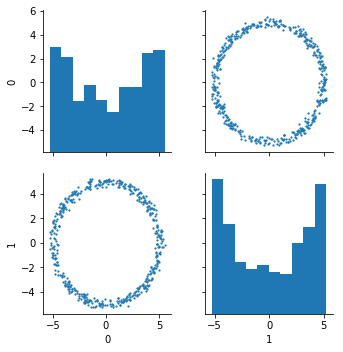

In [5]:
data = p.data[:500,:5]
df = pd.DataFrame(data)
sns.pairplot(df,  plot_kws=dict(s=5, alpha=1.0, linewidth=0))

In [8]:
dl_model = DKEFModels.DeepLite(p, npoint=200, nlayer=3, nneuron=15, 
                               init_log_lam=-2, init_log_sigma=np.logspace(0,1,1),
                               points_type="opt", step_size=1e-3, base=True, noise_std=0.0, init_weight_std=1.0,
                               niter=1000, ntrain=100, nvalid=100, patience=200, seed=0,
                               final_ntrain = 100, final_nvalid=100, final_niter = 1000, final_step_size=1e-3,
                               gpu_count=1, curve_penalty=True, add_skip=True)
kernel_res, alpha_res, logZ = dl_model.fit(0)

   trainining kernel: 100%|█| 1001/1001 [03:44<00:00,  6.48it/s[{'test': '-11.443', 'loss': '-11.896'}]]


INFO:tensorflow:Restoring parameters from ckpts/R_D02_l3_nd15_np200_nt100_nv100_pto_ss10_ni1000_n00_k10_m0_b1_p200_nk1_cl0_cu1_s00.ckpt


  accumulating stats:  22%|████████▉                               | 18/81 [00:00<00:00, 178.36it/s]

best score: -11.44301


      fitting lambda: 100%|█████████████████████████████████████| 1000/1000 [00:15<00:00, 65.88it/s]


final validation score: -11.472


In [9]:
ll = dl_model.eval(p.test_data, n=10**7).mean()
print ll

estimating logZ: 100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 98.50it/s]


-3.33829526287


/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


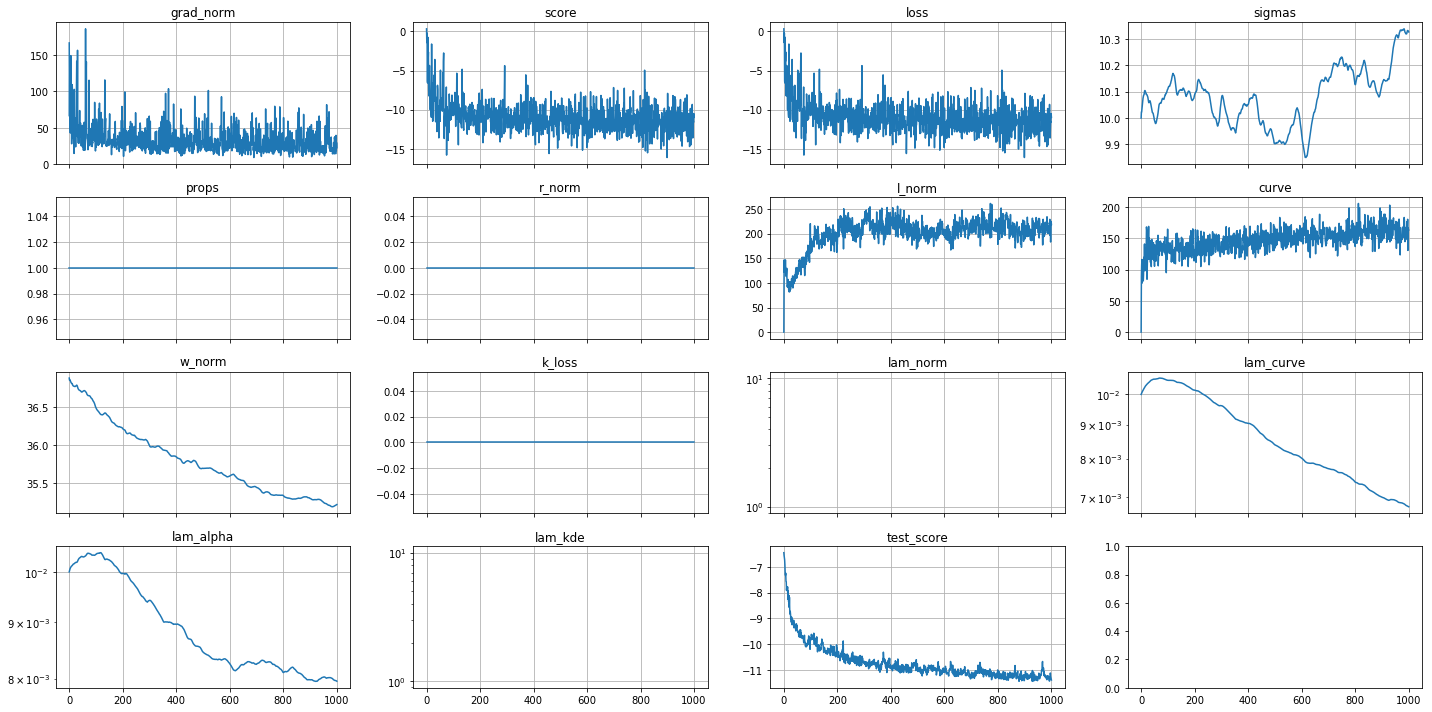

In [10]:
fig, axes = plt.subplots(4,4,figsize=(20,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")

fig.tight_layout()

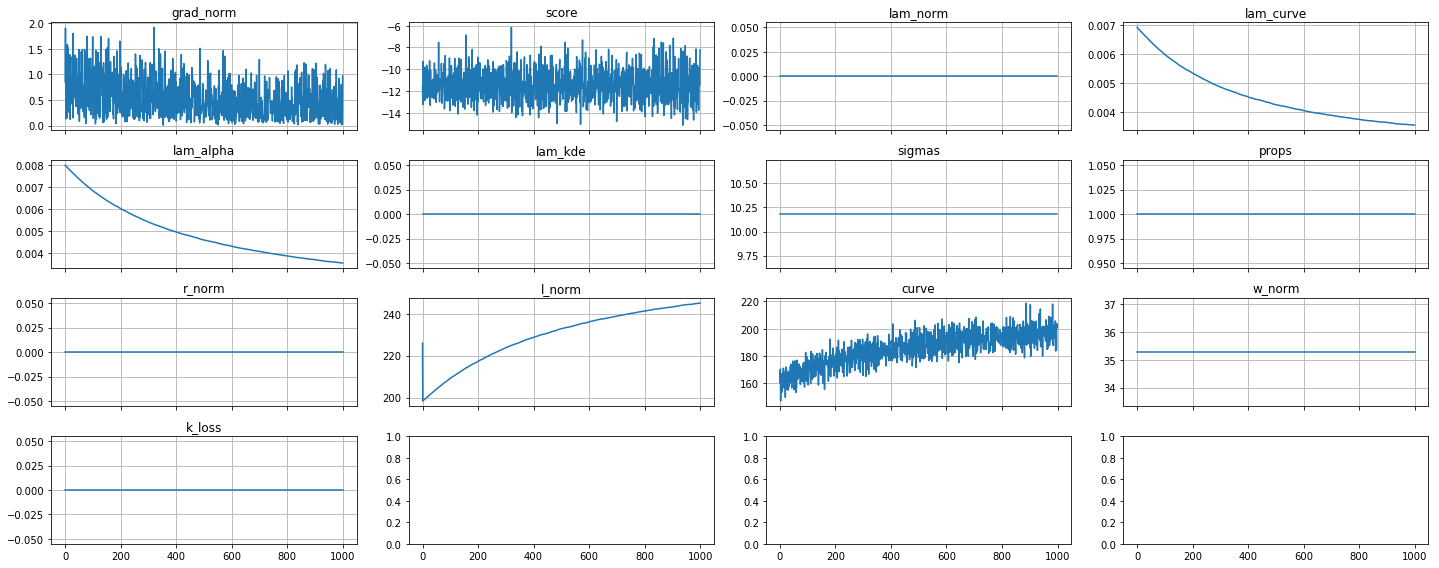

In [11]:
fig, axes = plt.subplots(4,4,figsize=(20,8), sharex=True)
axes = axes.flatten()
res = dl_model.final_state_hist
for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    ax.grid("on")

fig.tight_layout()

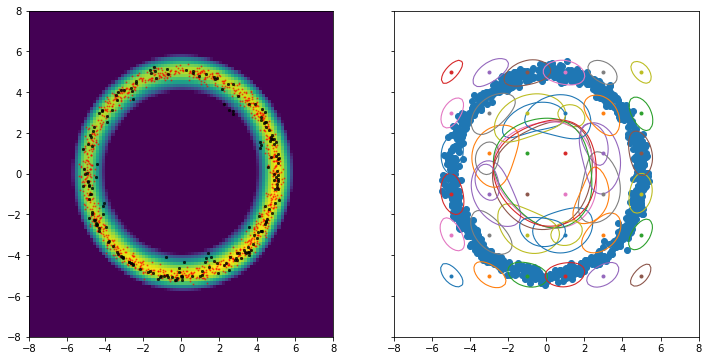

In [13]:
idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


logpdf = dl_model.fun_multiple(eval_points)
logpdf -= logpdf.max()

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-9)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())


ax = axes[1]
grid_points = get_grid(np.linspace(-5,5,6), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kernel_vals = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})

    for i in range(kernel_vals.shape[0]):
        kv = kernel_vals[i]
        ax.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+1)])
        ax.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
ax.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j])